In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing libraries

In [326]:
from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

In [2]:
import os,glob

In [3]:
import PIL.Image  as Image
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import pywt
from skimage import feature

In [5]:
from torch_utils import gauss_filter, poisson_filter, salt_pepper_filter, speckle_filter

In [6]:
from torchvision.transforms import FiveCrop

In [7]:
tr_dir = '/notebooks/data/cameras/train/'
tt_dir = '/notebooks/data/cameras/test/'

# Choosing resources to extrac the features

In [8]:
dire = tr_dir +'123.jpg'
dire.split('cameras/')[1].split('/')[1]

'123.jpg'

In [9]:
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:            15G        589M        3.5G        7.8M         11G         14G
Swap:           15G        720M         15G
Thu Apr 19 16:50:11 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 660 Ti  Off  | 00000000:01:00.0 N/A |                  N/A |
| 30%   33C    P8    N/A /  N/A |     29MiB /  1997MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                            

# Creating Dataset & DataLoader

In [10]:
labels = os.listdir(tr_dir)
labels

['Motorola-Nexus-6',
 'LG-Nexus-5x',
 'Motorola-Droid-Maxx',
 'Samsung-Galaxy-S4',
 'iPhone-6',
 'HTC-1-M7',
 'Motorola-X',
 'Samsung-Galaxy-Note3',
 'Sony-NEX-7',
 'iPhone-4s']

In [162]:
X_tr = []
y_tr = []
for i, label in enumerate(labels):
    if label == labels[-2]: 
        ext = '*.JPG'
    else : ext= '*.jpg'
    path_folder = os.path.join(tr_dir, str(label),ext)
    files = glob.glob(path_folder) 
    X_tr.extend(files)
    y_tr.extend([i]*len(files))
    print(f"{label}: {len(files)}")

len(X_tr),len(y_tr)

Motorola-Nexus-6: 275
LG-Nexus-5x: 275
Motorola-Droid-Maxx: 275
Samsung-Galaxy-S4: 275
iPhone-6: 275
HTC-1-M7: 275
Motorola-X: 275
Samsung-Galaxy-Note3: 275
Sony-NEX-7: 275
iPhone-4s: 275


(2750, 2750)

In [44]:
np.unique(y_tr,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([275, 275, 275, 275, 275, 275, 275, 275, 275, 275]))

# Extracting features 

In [15]:
import math
def get_crop(img, crop_size=512, random_crop=False):
    img = np.array(img)
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    half_crop = crop_size // 2
    pad_x = max(0, crop_size - img.shape[1])
    pad_y = max(0, crop_size - img.shape[0])
    if (pad_x > 0) or (pad_y > 0):
        img = np.pad(img, ((pad_y//2, pad_y - pad_y//2), (pad_x//2, pad_x - pad_x//2), (0,0)), mode='wrap')
        center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    if random_crop:
        freedom_x, freedom_y = img.shape[1] - crop_size, img.shape[0] - crop_size
        if freedom_x > 0:
            center_x += np.random.randint(math.ceil(-freedom_x/2), freedom_x - math.floor(freedom_x/2) )
        if freedom_y > 0:
            center_y += np.random.randint(math.ceil(-freedom_y/2), freedom_y - math.floor(freedom_y/2) )
    res = img[center_y - half_crop : center_y + crop_size - half_crop, center_x - half_crop : center_x + crop_size - half_crop]
    return res.astype('uint8')

In [16]:
# https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
 
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
        self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
        bins=np.arange(0, self.numPoints + 3),
        range=(0, self.numPoints + 2))
 
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
 
        # return the histogram of Local Binary Patterns
        return hist

In [86]:
lbp = LocalBinaryPatterns(50, 8)

In [19]:
multicrop = FiveCrop(512)

In [17]:
def w2d(img, mode='haar', level=1):
    imArray = cv2.imread(img)
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    #Display result
    cv2.imshow('image',imArray_H)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

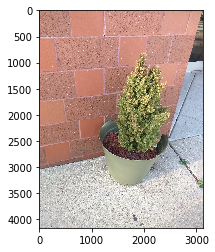

In [48]:
im = Image.open(X_tr[0])
plt.imshow(im)

In [49]:
crops = multicrop(im)

In [50]:
im.height,im.width

(4160, 3120)

In [87]:
lbp.describe(np.array(crops[0])[:,:,0]).shape

(52,)

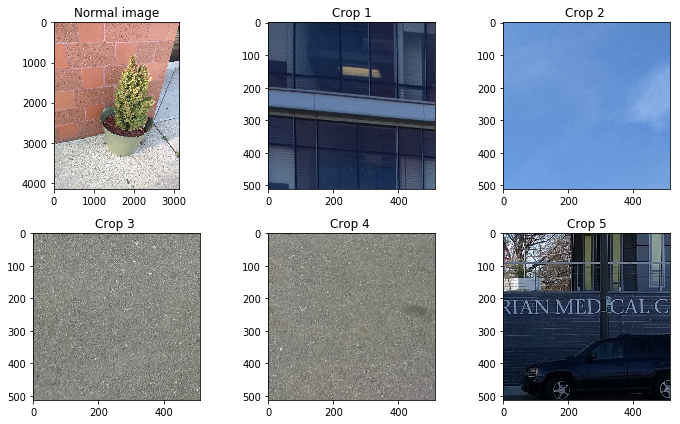

In [68]:
fig = plt.figure()

fig.set_figheight(6)
fig.set_figwidth(10)

ax1 = fig.add_subplot(2,3,1)
ax1.imshow(im)
ax1.set_title('Normal image')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(crops[0]) 
ax2.set_title('Crop 1')

ax3 = fig.add_subplot(2,3,3)
ax3.imshow(crops[1])  # 50% darker
ax3.set_title('Crop 2 ')

ax4 = fig.add_subplot(2,3,4)
ax4.imshow(crops[2])
ax4.set_title('Crop 3 ')

ax5 = fig.add_subplot(2,3,5)
ax5.imshow(crops[3]) # 50% brighter
ax5.set_title('Crop 4 ')

ax6 = fig.add_subplot(2,3,6)
ax6.imshow(crops[4])  # 50% darker
ax6.set_title('Crop 5')
plt.tight_layout()
plt.show()

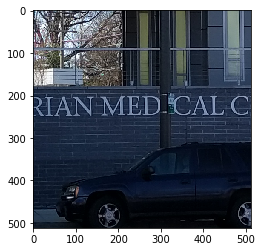

In [69]:
plt.imshow(crops[4])

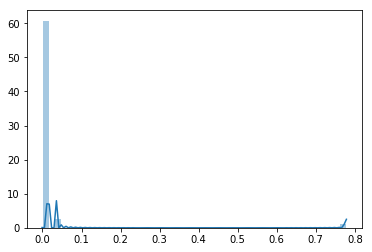

In [84]:
sns.distplot(lbp.describe(np.array(crops[1])[:,:,0]))

In [61]:
noise = np.uint8(np.array(cr_im) - np.array(cr_im.filter(ImageFilter.MedianFilter(5))))

AttributeError: 'numpy.ndarray' object has no attribute 'filter'

In [19]:
plt.imshow(noise)

NameError: name 'noise' is not defined

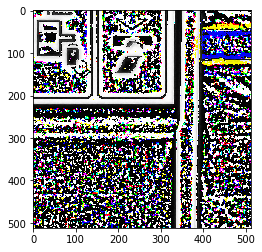

In [64]:
noise = np.uint8(np.array(cr_im) - np.array(cr_im.filter(ImageFilter.GaussianBlur(5))))
plt.imshow(noise)

In [18]:
from PIL import ImageFilter

def noise_gauss(img):
    return np.array(img).astype(float) - np.array(img.filter(ImageFilter.GaussianBlur(5))).astype(float)
def noise_mean(img):
    return np.array(img).astype(float) - np.array(img.filter(ImageFilter.MedianFilter(5))).astype(float)
def noise_max(img):
    return (np.array(img) - np.array(img.filter(ImageFilter.MaxFilter(5))) ).astype(float)
def noise_min(img):
    return (np.array(img) - np.array(img.filter(ImageFilter.MinFilter(5))) ).astype(float)
def noise_mode(img):
    return (np.array(img) - np.array(img.filter(ImageFilter.ModeFilter(5))) ).astype(float)


In [40]:
for idx,item in enumerate([22,2,3]): print(idx)

0
1
2


In [42]:
np.zeros((5,1)) +1

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [350]:
import random
from io import BytesIO
import math

import skimage
from PIL import Image
import jpeg4py as jpeg
import cv2

MANIPULATIONS = ['jpg70', 'jpg90', 'gamma0.8', 'gamma1.2', 'bicubic0.5', 'bicubic0.8', 'bicubic1.5', 'bicubic2.0']



def random_manipulation(img, manipulation=None):

    if manipulation == None:
        manipulation = random.choice(MANIPULATIONS)

    if manipulation.startswith('jpg'):
        quality = int(manipulation[3:])
        out = BytesIO()
        im = Image.fromarray(img)
        im.save(out, format='jpeg', quality=quality)
        im_decoded = jpeg.JPEG(np.frombuffer(out.getvalue(), dtype=np.uint8)).decode()
        del out
        del im
    elif manipulation.startswith('gamma'):
        gamma = float(manipulation[5:])
        # alternatively use skimage.exposure.adjust_gamma
        # img = skimage.exposure.adjust_gamma(img, gamma)
        im_decoded = np.uint8(cv2.pow(img / 255., gamma)*255.)
    elif manipulation.startswith('bicubic'):
        scale = float(manipulation[7:])
        im_decoded = cv2.resize(img,(0,0), fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
    else:
        assert False
    return im_decoded

In [408]:
Noises ={'gauss':[],'mean':[]}
#noises_fn = [noise_gauss,noise_mean]

lbp_features ={'red':[],'green':[],'blue':[],'class':[]}
#cls = np.zeros((5,1))

import time

for idx,imagePath in enumerate(X_tr):
    start_time = time.time()

    img = Image.open(imagePath)
    
    img = random_manipulation(np.array(img))

    img = Image.fromarray(img.astype('uint8'),'RGB')
    
    crops = multicrop(img) 
    
    r_feat = []
    g_feat = []
    b_feat = []
    for crop in crops: 
        crop = np.array(crop)

        r, g, b = crop[:,:,0],crop[:,:,1],crop[:,:,2]         # split channels        

        r_feat.append(lbp.describe(r))
        g_feat.append(lbp.describe(g))
        b_feat.append(lbp.describe(b))

    lbp_features['red'].append(np.array(r_feat))
    lbp_features['green'].append(np.array(g_feat))
    lbp_features['blue'].append(np.array(b_feat))
    cls = np.zeros((5,1)) +y_tr[idx]
    lbp_features['class'].append(cls)

    
#    img = Image.fromarray(img.astype('uint8'), 'RGB')

#    for idx,key in enumerate(Noises.keys()):

#        noise = noises_fn[idx](img)                                 #  extract noise
#        Noises[key].append(noise)
    
    end_time = time.time()

    print(f"Time {round(end_time-start_time,3)} : {idx}/{len(X_full)} ") #Features extracted from {imagePath.split('cameras/')[1].split('/')[1]}    

Time 3.424 : 0/2750 
Time 3.016 : 1/2750 
Time 3.007 : 2/2750 
Time 3.083 : 3/2750 
Time 3.06 : 4/2750 
Time 2.974 : 5/2750 
Time 3.301 : 6/2750 
Time 3.117 : 7/2750 
Time 3.103 : 8/2750 
Time 3.583 : 9/2750 
Time 3.326 : 10/2750 
Time 3.478 : 11/2750 
Time 3.007 : 12/2750 
Time 3.514 : 13/2750 
Time 3.128 : 14/2750 
Time 3.548 : 15/2750 
Time 2.979 : 16/2750 
Time 3.061 : 17/2750 
Time 3.524 : 18/2750 
Time 3.543 : 19/2750 
Time 3.256 : 20/2750 
Time 3.525 : 21/2750 
Time 3.135 : 22/2750 
Time 3.017 : 23/2750 
Time 3.085 : 24/2750 
Time 3.157 : 25/2750 
Time 3.025 : 26/2750 
Time 3.099 : 27/2750 
Time 3.223 : 28/2750 
Time 3.509 : 29/2750 
Time 3.148 : 30/2750 
Time 3.524 : 31/2750 
Time 3.077 : 32/2750 
Time 3.357 : 33/2750 
Time 3.531 : 34/2750 
Time 3.602 : 35/2750 
Time 3.516 : 36/2750 
Time 2.963 : 37/2750 
Time 3.032 : 38/2750 
Time 3.312 : 39/2750 
Time 3.102 : 40/2750 
Time 3.443 : 41/2750 
Time 3.04 : 42/2750 
Time 3.068 : 43/2750 
Time 3.427 : 44/2750 
Time 2.972 : 45/2750 


Time 3.176 : 363/2750 
Time 3.396 : 364/2750 
Time 2.974 : 365/2750 
Time 2.999 : 366/2750 
Time 3.399 : 367/2750 
Time 3.053 : 368/2750 
Time 3.244 : 369/2750 
Time 3.058 : 370/2750 
Time 3.559 : 371/2750 
Time 3.09 : 372/2750 
Time 3.368 : 373/2750 
Time 3.542 : 374/2750 
Time 2.985 : 375/2750 
Time 2.933 : 376/2750 
Time 3.601 : 377/2750 
Time 3.633 : 378/2750 
Time 3.386 : 379/2750 
Time 3.107 : 380/2750 
Time 3.451 : 381/2750 
Time 2.98 : 382/2750 
Time 3.477 : 383/2750 
Time 3.028 : 384/2750 
Time 3.213 : 385/2750 
Time 3.416 : 386/2750 
Time 3.448 : 387/2750 
Time 3.06 : 388/2750 
Time 3.563 : 389/2750 
Time 3.036 : 390/2750 
Time 2.938 : 391/2750 
Time 3.04 : 392/2750 
Time 3.502 : 393/2750 
Time 3.054 : 394/2750 
Time 3.591 : 395/2750 
Time 3.535 : 396/2750 
Time 2.948 : 397/2750 
Time 3.409 : 398/2750 
Time 3.004 : 399/2750 
Time 3.002 : 400/2750 
Time 3.383 : 401/2750 
Time 3.351 : 402/2750 
Time 3.536 : 403/2750 
Time 3.371 : 404/2750 
Time 3.232 : 405/2750 
Time 3.519 : 40

Time 3.008 : 721/2750 
Time 3.447 : 722/2750 
Time 3.004 : 723/2750 
Time 3.259 : 724/2750 
Time 3.349 : 725/2750 
Time 3.303 : 726/2750 
Time 3.345 : 727/2750 
Time 3.46 : 728/2750 
Time 2.988 : 729/2750 
Time 3.181 : 730/2750 
Time 3.347 : 731/2750 
Time 2.986 : 732/2750 
Time 2.935 : 733/2750 
Time 3.223 : 734/2750 
Time 3.285 : 735/2750 
Time 3.03 : 736/2750 
Time 3.37 : 737/2750 
Time 3.332 : 738/2750 
Time 3.376 : 739/2750 
Time 3.317 : 740/2750 
Time 2.938 : 741/2750 
Time 3.262 : 742/2750 
Time 3.138 : 743/2750 
Time 2.928 : 744/2750 
Time 3.28 : 745/2750 
Time 2.993 : 746/2750 
Time 3.334 : 747/2750 
Time 3.007 : 748/2750 
Time 2.979 : 749/2750 
Time 3.367 : 750/2750 
Time 3.27 : 751/2750 
Time 2.967 : 752/2750 
Time 3.402 : 753/2750 
Time 3.323 : 754/2750 
Time 3.296 : 755/2750 
Time 2.991 : 756/2750 
Time 3.333 : 757/2750 
Time 3.191 : 758/2750 
Time 2.977 : 759/2750 
Time 2.986 : 760/2750 
Time 3.356 : 761/2750 
Time 3.065 : 762/2750 
Time 2.988 : 763/2750 
Time 3.378 : 764

Time 3.134 : 1076/2750 
Time 3.33 : 1077/2750 
Time 2.981 : 1078/2750 
Time 3.277 : 1079/2750 
Time 3.294 : 1080/2750 
Time 2.895 : 1081/2750 
Time 2.926 : 1082/2750 
Time 3.329 : 1083/2750 
Time 3.127 : 1084/2750 
Time 2.922 : 1085/2750 
Time 3.144 : 1086/2750 
Time 3.177 : 1087/2750 
Time 3.25 : 1088/2750 
Time 2.994 : 1089/2750 
Time 2.949 : 1090/2750 
Time 2.981 : 1091/2750 
Time 3.241 : 1092/2750 
Time 3.016 : 1093/2750 
Time 2.995 : 1094/2750 
Time 3.092 : 1095/2750 
Time 3.153 : 1096/2750 
Time 3.328 : 1097/2750 
Time 3.315 : 1098/2750 
Time 3.09 : 1099/2750 
Time 3.161 : 1100/2750 
Time 3.177 : 1101/2750 
Time 2.925 : 1102/2750 
Time 2.918 : 1103/2750 
Time 3.165 : 1104/2750 
Time 3.239 : 1105/2750 
Time 3.066 : 1106/2750 
Time 3.255 : 1107/2750 
Time 2.933 : 1108/2750 
Time 2.969 : 1109/2750 
Time 2.945 : 1110/2750 
Time 2.933 : 1111/2750 
Time 2.947 : 1112/2750 
Time 2.957 : 1113/2750 
Time 3.147 : 1114/2750 
Time 2.937 : 1115/2750 
Time 3.107 : 1116/2750 
Time 3.221 : 1117/2

Time 2.815 : 1419/2750 
Time 2.993 : 1420/2750 
Time 3.042 : 1421/2750 
Time 2.778 : 1422/2750 
Time 2.991 : 1423/2750 
Time 2.803 : 1424/2750 
Time 3.004 : 1425/2750 
Time 2.806 : 1426/2750 
Time 2.832 : 1427/2750 
Time 2.834 : 1428/2750 
Time 2.844 : 1429/2750 
Time 3.048 : 1430/2750 
Time 2.964 : 1431/2750 
Time 3.02 : 1432/2750 
Time 2.842 : 1433/2750 
Time 2.978 : 1434/2750 
Time 2.801 : 1435/2750 
Time 2.913 : 1436/2750 
Time 2.817 : 1437/2750 
Time 2.913 : 1438/2750 
Time 3.003 : 1439/2750 
Time 2.798 : 1440/2750 
Time 2.896 : 1441/2750 
Time 2.979 : 1442/2750 
Time 2.768 : 1443/2750 
Time 2.812 : 1444/2750 
Time 2.933 : 1445/2750 
Time 2.936 : 1446/2750 
Time 2.833 : 1447/2750 
Time 2.831 : 1448/2750 
Time 2.771 : 1449/2750 
Time 2.853 : 1450/2750 
Time 2.987 : 1451/2750 
Time 2.865 : 1452/2750 
Time 2.999 : 1453/2750 
Time 2.882 : 1454/2750 
Time 2.978 : 1455/2750 
Time 2.929 : 1456/2750 
Time 2.841 : 1457/2750 
Time 2.994 : 1458/2750 
Time 3.021 : 1459/2750 
Time 2.819 : 1460

Time 3.512 : 1762/2750 
Time 2.982 : 1763/2750 
Time 3.077 : 1764/2750 
Time 3.494 : 1765/2750 
Time 3.599 : 1766/2750 
Time 3.329 : 1767/2750 
Time 3.564 : 1768/2750 
Time 3.535 : 1769/2750 
Time 3.48 : 1770/2750 
Time 3.019 : 1771/2750 
Time 2.985 : 1772/2750 
Time 3.46 : 1773/2750 
Time 3.567 : 1774/2750 
Time 3.343 : 1775/2750 
Time 2.995 : 1776/2750 
Time 3.017 : 1777/2750 
Time 3.103 : 1778/2750 
Time 3.335 : 1779/2750 
Time 3.544 : 1780/2750 
Time 3.06 : 1781/2750 
Time 3.556 : 1782/2750 
Time 3.472 : 1783/2750 
Time 2.982 : 1784/2750 
Time 3.079 : 1785/2750 
Time 3.02 : 1786/2750 
Time 3.072 : 1787/2750 
Time 3.08 : 1788/2750 
Time 3.113 : 1789/2750 
Time 3.548 : 1790/2750 
Time 3.097 : 1791/2750 
Time 3.508 : 1792/2750 
Time 3.091 : 1793/2750 
Time 3.115 : 1794/2750 
Time 3.114 : 1795/2750 
Time 3.01 : 1796/2750 
Time 3.03 : 1797/2750 
Time 3.558 : 1798/2750 
Time 3.381 : 1799/2750 
Time 3.552 : 1800/2750 
Time 3.032 : 1801/2750 
Time 3.644 : 1802/2750 
Time 3.102 : 1803/2750 

Time 3.128 : 2105/2750 
Time 2.943 : 2106/2750 
Time 3.287 : 2107/2750 
Time 3.313 : 2108/2750 
Time 3.281 : 2109/2750 
Time 2.956 : 2110/2750 
Time 3.179 : 2111/2750 
Time 2.95 : 2112/2750 
Time 2.876 : 2113/2750 
Time 2.966 : 2114/2750 
Time 3.296 : 2115/2750 
Time 3.096 : 2116/2750 
Time 3.311 : 2117/2750 
Time 2.967 : 2118/2750 
Time 3.124 : 2119/2750 
Time 3.334 : 2120/2750 
Time 3.134 : 2121/2750 
Time 3.172 : 2122/2750 
Time 3.09 : 2123/2750 
Time 2.982 : 2124/2750 
Time 2.93 : 2125/2750 
Time 2.989 : 2126/2750 
Time 3.019 : 2127/2750 
Time 2.945 : 2128/2750 
Time 2.974 : 2129/2750 
Time 3.053 : 2130/2750 
Time 3.182 : 2131/2750 
Time 2.911 : 2132/2750 
Time 2.984 : 2133/2750 
Time 2.966 : 2134/2750 
Time 2.975 : 2135/2750 
Time 2.939 : 2136/2750 
Time 2.917 : 2137/2750 
Time 3.336 : 2138/2750 
Time 3.322 : 2139/2750 
Time 2.906 : 2140/2750 
Time 3.031 : 2141/2750 
Time 3.179 : 2142/2750 
Time 3.275 : 2143/2750 
Time 2.961 : 2144/2750 
Time 2.985 : 2145/2750 
Time 2.931 : 2146/2

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2509: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Time 3.437 : 2207/2750 
Time 3.308 : 2208/2750 
Time 3.292 : 2209/2750 
Time 3.246 : 2210/2750 
Time 3.372 : 2211/2750 
Time 3.7 : 2212/2750 
Time 4.2 : 2213/2750 
Time 3.821 : 2214/2750 
Time 3.674 : 2215/2750 
Time 3.232 : 2216/2750 
Time 4.202 : 2217/2750 
Time 4.172 : 2218/2750 
Time 3.288 : 2219/2750 
Time 4.182 : 2220/2750 
Time 3.42 : 2221/2750 
Time 3.139 : 2222/2750 
Time 3.324 : 2223/2750 
Time 3.3 : 2224/2750 
Time 3.297 : 2225/2750 
Time 4.14 : 2226/2750 
Time 3.971 : 2227/2750 
Time 3.247 : 2228/2750 
Time 3.896 : 2229/2750 
Time 4.155 : 2230/2750 
Time 4.182 : 2231/2750 
Time 3.412 : 2232/2750 
Time 3.693 : 2233/2750 
Time 3.715 : 2234/2750 
Time 3.699 : 2235/2750 
Time 3.203 : 2236/2750 
Time 3.267 : 2237/2750 
Time 3.29 : 2238/2750 
Time 3.29 : 2239/2750 
Time 3.88 : 2240/2750 
Time 3.174 : 2241/2750 
Time 3.205 : 2242/2750 
Time 3.711 : 2243/2750 
Time 3.831 : 2244/2750 
Time 3.846 : 2245/2750 
Time 3.726 : 2246/2750 
Time 3.448 : 2247/2750 
Time 3.39 : 2248/2750 
Time

Time 3.305 : 2551/2750 
Time 3.008 : 2552/2750 
Time 2.966 : 2553/2750 
Time 2.971 : 2554/2750 
Time 3.072 : 2555/2750 
Time 2.923 : 2556/2750 
Time 2.951 : 2557/2750 
Time 3.125 : 2558/2750 
Time 3.131 : 2559/2750 
Time 3.049 : 2560/2750 
Time 2.95 : 2561/2750 
Time 3.295 : 2562/2750 
Time 3.045 : 2563/2750 
Time 2.977 : 2564/2750 
Time 3.203 : 2565/2750 
Time 3.059 : 2566/2750 
Time 2.923 : 2567/2750 
Time 2.917 : 2568/2750 
Time 2.879 : 2569/2750 
Time 2.917 : 2570/2750 
Time 2.929 : 2571/2750 
Time 2.902 : 2572/2750 
Time 3.037 : 2573/2750 
Time 2.939 : 2574/2750 
Time 3.097 : 2575/2750 
Time 3.08 : 2576/2750 
Time 2.959 : 2577/2750 
Time 2.937 : 2578/2750 
Time 3.258 : 2579/2750 
Time 3.094 : 2580/2750 
Time 2.884 : 2581/2750 
Time 2.904 : 2582/2750 
Time 2.917 : 2583/2750 
Time 2.926 : 2584/2750 
Time 2.907 : 2585/2750 
Time 2.95 : 2586/2750 
Time 2.914 : 2587/2750 
Time 3.086 : 2588/2750 
Time 2.952 : 2589/2750 
Time 2.952 : 2590/2750 
Time 2.881 : 2591/2750 
Time 3.26 : 2592/27

In [414]:
lbp_features['blue'][0].shape

(5, 52)

In [415]:
np.savez('./lbp_features_MANIP.npz',**lbp_features)

In [416]:
lbp_features = np.load('./lbp_features_MANIP.npz')

In [417]:
def to_numpy(inp):
    return np.array(inp).reshape(2750,-1)

In [418]:
data = np.concatenate((to_numpy(lbp_features['red']),
                       to_numpy(lbp_features['green']),
                       to_numpy(lbp_features['blue']),
                       #to_numpy(lbp_features['class'])
                       ),axis=1)
data.shape

(2750, 780)

In [419]:
data = np.concatenate((data,np.array(y_tr).reshape(-1,1)),axis=1)
data.shape

(2750, 781)

In [420]:
for i in range(10): 
     print(data[data[:,-1]==i].shape)
    #print(len(y_full==1))

(275, 781)
(275, 781)
(275, 781)
(275, 781)
(275, 781)
(275, 781)
(275, 781)
(275, 781)
(275, 781)
(275, 781)


In [421]:
np.save('./TRAIN_lbp_features_MANIP.npy',data)

In [422]:
temp = np.load('./TRAIN_lbp_features_MANIP.npy')
temp.shape

(2750, 781)

In [423]:
del temp

In [424]:
np.unique(data[:,-1],return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([275, 275, 275, 275, 275, 275, 275, 275, 275, 275]))

In [425]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data[:,:-1],data[:,-1], test_size=0.2, random_state=42)

In [426]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2200, 780), (550, 780), (2200,), (550,))

In [427]:
np.unique(y_val,return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([58, 63, 51, 58, 53, 54, 48, 54, 64, 47]))

# Classifier

In [428]:
import itertools

def plot_confusion_matrix(cm, classes,figsize,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [429]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [430]:
sc_full = StandardScaler()
data_sc = sc.fit_transform(data[:,:-1])

In [431]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [432]:
from sklearn.metrics import classification_report,accuracy_score 
# Predicting the Test set results
y_pred = classifier.predict(X_val)


accuracy_score(y_val,y_pred)

0.6545454545454545

In [433]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

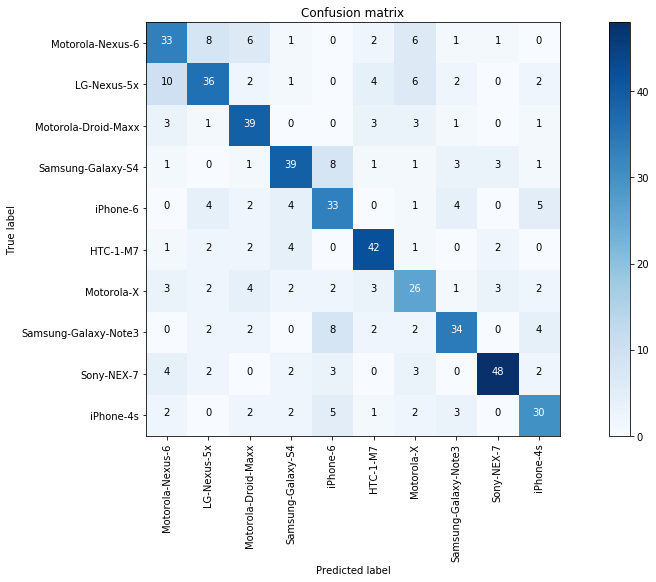

In [434]:
plot_confusion_matrix(cm,labels,(14,8))

In [401]:
print(classification_report(y_val, y_pred,target_names=labels))

                      precision    recall  f1-score   support

    Motorola-Nexus-6       0.68      0.66      0.67        58
         LG-Nexus-5x       0.71      0.70      0.70        63
 Motorola-Droid-Maxx       0.64      0.71      0.67        51
   Samsung-Galaxy-S4       0.72      0.76      0.74        58
            iPhone-6       0.70      0.58      0.64        53
            HTC-1-M7       0.78      0.87      0.82        54
          Motorola-X       0.49      0.48      0.48        48
Samsung-Galaxy-Note3       0.59      0.69      0.63        54
          Sony-NEX-7       0.92      0.84      0.88        64
           iPhone-4s       0.64      0.57      0.61        47

         avg / total       0.70      0.69      0.69       550



In [402]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import StratifiedKFold

In [405]:
def printing_Kfold_scores(x_train_data,y_train_data):
    #fold = KFold(len(y_train_data),5,shuffle=True) 
    skf = StratifiedKFold(5,shuffle=True) 
    
    # Different C parameters
    c_param_range = np.random.uniform(0.5, 1.5,size=5).tolist()
    #c_param_range = [0.01,0.1,1,10]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean acc score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        iteration = 0
        acc_accs = []
#        for iteration, indices in enumerate(fold,start=1):
        for train_index, test_index in skf.split(x_train_data, y_train_data):
        
        
            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data[train_index,:],y_train_data[train_index,:])

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data[test_index,:])

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            acc_acc = accuracy_score(y_train_data[test_index,:],y_pred_undersample)
            acc_accs.append(acc_acc)
            print('Iteration ', iteration,': acc score = ', acc_acc)
            iteration+=1

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j,'Mean acc score'] = np.mean(acc_accs)
        j += 1
        print('')
        print(f'Mean acc score  {np.mean(acc_accs)}')
        print('')

    best_c = results_table.loc[results_table['Mean acc score']==results_table['Mean acc score'].max()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [406]:
import pandas as pd
best_c = printing_Kfold_scores(data_sc[:,:-1],data[:,-1:])

-------------------------------------------
C parameter:  1.2341365348093427
-------------------------------------------



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration  0 : acc score =  0.6290909090909091
Iteration  1 : acc score =  0.64
Iteration  2 : acc score =  0.6763636363636364


KeyboardInterrupt: 

In [435]:
classifier = LogisticRegression(C=1.214324,random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.214324, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [436]:
y_pred = classifier.predict(X_val)

cm = confusion_matrix(y_val, y_pred)

In [437]:
accuracy_score(y_val,y_pred)

0.6545454545454545

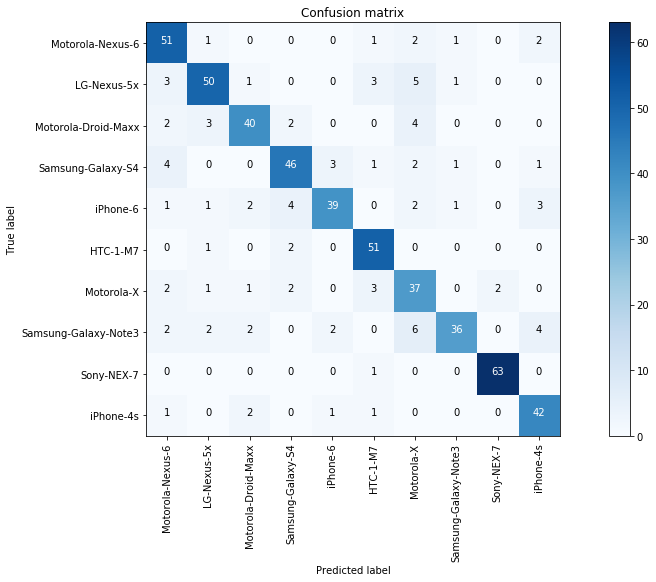

In [209]:
plot_confusion_matrix(cm,labels,(14,8))

In [210]:
import torch
import torch.nn.functional as F
import lib.pytorch_trainer as ptt
from torch.utils.data import DataLoader,Dataset
from torch_utils import ReduceLROnPlateau
from torch.autograd import Variable



In [301]:
class MLP(torch.nn.Module):
    def __init__(self,nclasses=10):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=780, out_features=1024)
        self.dens2 = torch.nn.Linear(in_features=1024, out_features=512)
        self.dens3 = torch.nn.Linear(in_features=512, out_features=nclasses)
        
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.sigmoid(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.dens2(x)
        x = torch.nn.functional.sigmoid(x)
        x = F.dropout(x, p=0.5, training=self.training)


        x = self.dens3(x)
        return x



In [312]:
model =MLP()

In [328]:
print(torch_summarize(model))

MLP (
  (dens1): Linear(in_features=780, out_features=1024), weights=((1024, 780), (1024,)), parameters=799744
  (dens2): Linear(in_features=1024, out_features=512), weights=((512, 1024), (512,)), parameters=524800
  (dens3): Linear(in_features=512, out_features=10), weights=((10, 512), (10,)), parameters=5130
)


In [313]:
inp = Variable(torch.rand(20,780))
model(inp).shape

torch.Size([20, 10])

In [314]:
model = model.cuda()

In [315]:
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-4)
scheduler = ReduceLROnPlateau(opt, factor=0.85, patience=30, min_lr=1e-9, epsilon=1e-5, verbose=1, mode='min')
savebest = ptt.ModelCheckpoint('./models/MLP',reset=True, verbose=1)

In [316]:
trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     opt,
        callbacks =     [ptt.AccuracyMetric(),savebest,ptt.PrintCallback()],
        lr_scheduler = scheduler,
        )

In [317]:
T_X_train,T_y_train = torch.FloatTensor(X_train.astype(float)),torch.LongTensor(y_train.astype(int))
T_X_val,T_y_val = torch.FloatTensor(X_val.astype(float)),torch.LongTensor(y_val.astype(int))

In [318]:
trainer.fit(300,T_X_train,T_y_train,valid_data=(T_X_val,T_y_val))

Start training for 300 epochs
  1:   0.6s   T: 2.29637 0.12955   V: 2.18841 0.27818 best
  2:   0.6s   T: 2.16792 0.21682   V: 2.07849 0.31636 best
  3:   0.6s   T: 2.04692 0.28045   V: 1.95957 0.32364 best
  4:   0.6s   T: 1.92813 0.33000   V: 1.85950 0.39636 best
  5:   0.6s   T: 1.82708 0.36273   V: 1.76399 0.41636 best
  6:   0.6s   T: 1.74144 0.40682   V: 1.68140 0.44545 best
  7:   0.6s   T: 1.66142 0.43727   V: 1.61285 0.47091 best
  8:   0.6s   T: 1.57740 0.46045   V: 1.53776 0.49818 best
  9:   0.6s   T: 1.51154 0.49818   V: 1.46385 0.54182 best
 10:   0.6s   T: 1.45172 0.53000   V: 1.40972 0.56909 best
 11:   0.6s   T: 1.38381 0.54455   V: 1.35424 0.55818 best
 12:   0.6s   T: 1.32991 0.56227   V: 1.30638 0.58727 best
 13:   0.6s   T: 1.28088 0.58364   V: 1.25240 0.60000 best
 14:   0.6s   T: 1.23995 0.59273   V: 1.21704 0.62000 best
 15:   0.6s   T: 1.18708 0.62227   V: 1.18288 0.62545 best
 16:   0.6s   T: 1.14454 0.63182   V: 1.15108 0.64364 best
 17:   0.6s   T: 1.10393 0

144:   0.6s   T: 0.21899 0.92318   V: 0.59062 0.82909 
145:   0.6s   T: 0.19688 0.93682   V: 0.56897 0.83091 
146:   0.6s   T: 0.20709 0.93000   V: 0.57839 0.83273 
147:   0.6s   T: 0.21111 0.93000   V: 0.56302 0.84182 
148:   0.6s   T: 0.19329 0.93955   V: 0.57254 0.83455 
149:   0.6s   T: 0.19235 0.93773   V: 0.59326 0.83455 
150:   0.6s   T: 0.20117 0.93227   V: 0.57165 0.83455 
151:   0.6s   T: 0.19499 0.94045   V: 0.56495 0.84364 
152:   0.6s   T: 0.21759 0.92727   V: 0.54183 0.85455 best
153:   0.6s   T: 0.19575 0.93955   V: 0.57988 0.84000 
154:   0.6s   T: 0.19584 0.93818   V: 0.55517 0.83818 
155:   0.6s   T: 0.20634 0.93364   V: 0.56736 0.83636 
156:   0.6s   T: 0.18022 0.94909   V: 0.56340 0.84182 
157:   0.6s   T: 0.18906 0.94045   V: 0.56879 0.84364 
158:   0.6s   T: 0.19767 0.94091   V: 0.56835 0.84364 
159:   0.6s   T: 0.19736 0.93727   V: 0.59250 0.83818 
160:   0.6s   T: 0.19534 0.93500   V: 0.55780 0.84000 
161:   0.6s   T: 0.19078 0.93955   V: 0.58029 0.84000 
162:  

289:   0.6s   T: 0.09761 0.97182   V: 0.59123 0.84364 
290:   0.6s   T: 0.10208 0.97136   V: 0.61149 0.84909 
291:   0.6s   T: 0.09008 0.97182   V: 0.61427 0.84545 
292:   0.6s   T: 0.09756 0.97091   V: 0.60933 0.84182 
293:   0.6s   T: 0.09279 0.97318   V: 0.60741 0.85091 
294:   0.6s   T: 0.08957 0.97136   V: 0.58924 0.85091 
295:   0.6s   T: 0.09352 0.97273   V: 0.60039 0.84727 
296:   0.6s   T: 0.09039 0.97227   V: 0.60208 0.84727 
297:   0.6s   T: 0.10226 0.96682   V: 0.60111 0.85091 
298:   0.6s   T: 0.10337 0.96818   V: 0.61166 0.83818 
299:   0.6s   T: 0.08559 0.97500   V: 0.60703 0.84364 
300:   0.6s   T: 0.09065 0.97000   V: 0.59965 0.84182 
Best model was saved at epoch 152 with loss 0.54183: ./models/MLP
Stop training at epoch: 300/300


In [311]:
trainer.save_state('./models/MLP_85')

In [309]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']) - 1)
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

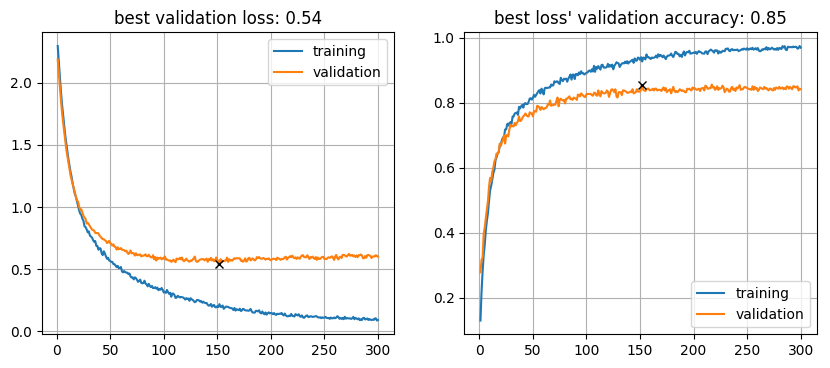

In [319]:
show_history(trainer)

In [322]:
y_pred = trainer.predict_classes(T_X_val)

cm = confusion_matrix(y_val, y_pred.cpu().numpy())

In [323]:
accuracy_score(y_val, y_pred.cpu().numpy())

0.8418181818181818

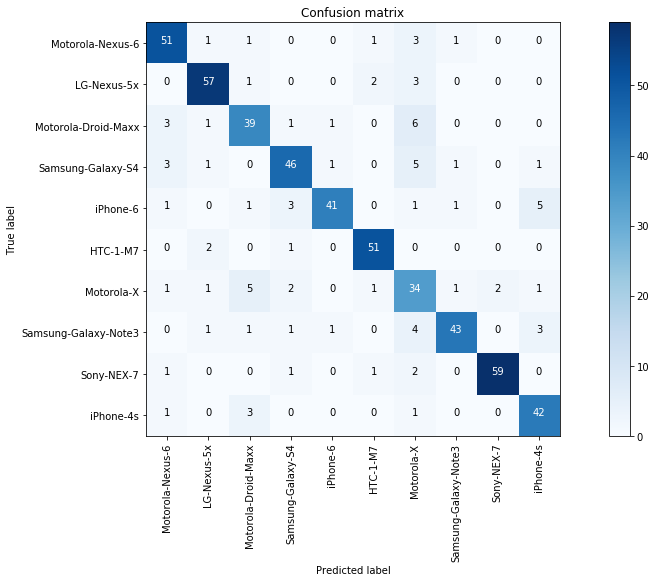

In [324]:
plot_confusion_matrix(cm,labels,(14,8))

In [330]:
import pandas as pd

In [438]:
path_folder = os.path.join(tt_dir,'*.tif')
X_test = glob.glob(path_folder) 
len(X_test)

2640

In [439]:
X_test[0].split('test/')[1]

'img_5d87857_manip.tif'

In [440]:
test_feat = np.load('./TEST_lbp_features.npy')
test_feat.shape

(2640, 780)

In [441]:
y_pred_MLP = trainer.predict_classes(torch.FloatTensor(test_feat.astype(float)).cuda())
y_pred_LR = classifier.predict(test_feat)

In [340]:
labels[y_pred_LR[0].astype(int)]

'Samsung-Galaxy-Note3'

In [442]:
res_LR = []
res_MLP = []

for idx,imagePath in enumerate(X_test):
    res_LR.append([imagePath.split('test/')[1], labels[int(y_pred_LR[idx])]  ])
    res_MLP.append([imagePath.split('test/')[1], labels[int(y_pred_MLP[idx])]  ])    


In [443]:
len(res_LR),len(res_MLP)

(2640, 0)

In [444]:
sub_LR = pd.DataFrame(res_LR,columns=['fname','camera'])
sub_MLP = pd.DataFrame(res_MLP,columns=['fname','camera'])

In [445]:
sub_LR.head(5)

,fname,camera
0,img_5d87857_manip.tif,Motorola-X
1,img_18d0ade_manip.tif,Motorola-X
2,img_4855385_unalt.tif,Motorola-X
3,img_a017012_unalt.tif,Motorola-X
4,img_470c361_unalt.tif,Motorola-X


In [446]:
sub_LR.to_csv('./submission_LR.csv',index=False)
sub_MLP.to_csv('./submission_MLP.csv',index=False)